In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1ce86062f1aab44f3fa40cc66422fe8e3d131271614da243799dd6b0ad107a0b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
filename = wget.download(url)

In [ ]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
filename = wget.download(url)

In [ ]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
filename = wget.download(url)

In [ ]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'  # Images
annotations_bbox_file = 'train-annotations-bbox.csv'         # containing boundingbox
class_descriptions_file = 'class-descriptions-boxable.csv'  # contains label and class name

In [ ]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [ ]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [ ]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [ ]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
from urllib.error import HTTPError

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class_descriptions[1].count()

601

In [ ]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

In [ ]:
bed_pd

,0,1
257,/m/03ssj5,Bed


In [ ]:
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

In [ ]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
5953,00041cc3701f7805,xclick,/m/03ssj5,1,0.135112,0.366609,0.420573,0.625000,1,0,0,0,0
5954,00041cc3701f7805,xclick,/m/03ssj5,1,0.179862,0.405336,0.436198,0.856771,0,0,0,0,0
9974,00074503ceae5131,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.999062,1,1,0,0,0
13671,000a54f1bdb96839,xclick,/m/03ssj5,1,0.000000,0.999167,0.028125,0.999375,0,1,0,0,0
17469,000da932ca7e68e4,xclick,/m/03ssj5,1,0.000000,0.753125,0.328330,0.993433,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585203,ff7f55b7f6794f63,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.997500,1,1,0,0,0
14595452,ffb716498f082103,xclick,/m/03ssj5,1,0.180000,0.998750,0.309568,0.998124,0,0,0,0,0
14600295,ffce182988b6b746,xclick,/m/03ssj5,1,0.000000,0.305625,0.707317,0.999062,0,1,0,0,0
14602507,ffd718211ba34626,activemil,/m/03ssj5,1,0.006250,0.207500,0.373333,0.805000,1,1,0,0,0


In [ ]:
print('There are %d beds in the dataset' %(len(bed_bbox)))
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [ ]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# working on 10 images
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

In [ ]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

In [ ]:
print("Beds:",subbed_pd.shape, "Chair:", subchair_pd.shape, "Tables:", subtable_pd.shape)

Beds: (10, 12) Chair: (10, 12) Tables: (10, 12)


In [ ]:
subbed_pd.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
62978,c7b116f2c0688794,train,https://farm5.staticflickr.com/5742/2138613194...,https://www.flickr.com/photos/15216811@N06/213...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/15216811@N06/,N i c o l a,Cameretta V2 - IMG_4551,1071863,u2jQz5HqNTBsGzn9yIaa3A==,https://c1.staticflickr.com/6/5742/21386131945...,0.0
120141,57db3f773ca7c646,train,https://farm7.staticflickr.com/7316/1651647401...,https://www.flickr.com/photos/sswain_1999/1651...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/sswain_1999/,Sadasiv Swain,Bhala Nani with left # neck of femur,191174,lFTR2u4xSBjLUmv8K1RegA==,https://c5.staticflickr.com/8/7316/16516474015...,0.0
122886,8fdc17686edf64a7,train,https://farm8.staticflickr.com/7250/6934222538...,https://www.flickr.com/photos/dgmckelvey/69342...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/dgmckelvey/,David McKelvey,"Artificial Tree, Concourse E, Suvarnabhumi Air...",2010404,Ut4deasZMZ3l7NxLc7AxNA==,https://c8.staticflickr.com/8/7250/6934222538_...,NaN
504041,981430da49976c20,train,https://farm1.staticflickr.com/3382/3601574707...,https://www.flickr.com/photos/beccadoodles/360...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/beccadoodles/,rebecca small,my date Vasean!,825456,D7v9G4nkiJH1BbXwZqqkvQ==,https://c5.staticflickr.com/4/3382/3601574707_...,0.0
508773,89ffc4add8d763a0,train,https://farm1.staticflickr.com/5079/5862099187...,https://www.flickr.com/photos/friarsbalsam/586...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/friarsbalsam/,Christopher John SSF,20110602_SSF_house_Assisi_011,989558,SqOz1luhC+o2VVXVWovIAw==,https://c3.staticflickr.com/6/5079/5862099187_...,0.0


In [ ]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
mappings = [subbed_dict, subchair_dict, subtable_dict]

In [ ]:
classes = ['Bed', 'Chair', 'Table']

In [ ]:
# download images in folders(Bed, Chair and table folder with 10 images each)


for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 1
Images Issues: 0


In [37]:
# save images to train and test directory, so create 2 folders
train_path = '/content/train/'
test_path = '/content/test/'

In [38]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)

    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]


    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)


    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [40]:
train_img_count = os.listdir('/content/test')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  8


In [39]:

test_img_count = os.listdir('/content/train')
print("Number of images in train found: ", len(test_img_count))

Number of images in train found:  28


In [47]:
import pandas as pd
import os

# Initialize an empty DataFrame with the correct columns
train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Assuming these are your label names and classes
label_names = [label_name_bed, label_name_chair, label_name_table]
classes = ['bed', 'chair', 'table']

# Assuming annotations_bbox is your existing DataFrame
# and train_path is your path to training images
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for img_name in train_imgs:
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID'] == img_id]

    data_to_append = []

    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                data_to_append.append({
                    'FileName': img_name,
                    'XMin': row['XMin'],
                    'XMax': row['XMax'],
                    'YMin': row['YMin'],
                    'YMax': row['YMax'],
                    'ClassName': classes[i]
                })

    if data_to_append:
        train_df = pd.concat([train_df, pd.DataFrame(data_to_append)], ignore_index=True)

    sys.stdout.write(f'Parsed train_imgs {img_name}; Number of boxes: {len(train_df)}\r')
    sys.stdout.flush()

# Optionally reset index if needed
train_df.reset_index(drop=True, inplace=True)

# Now train_df should contain all the data you need


In [48]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,d1cc93a77a52b7a2.jpg,0.695836,0.861680,0.611702,0.978723,chair
1,d1cc93a77a52b7a2.jpg,0.000000,0.039520,0.567021,0.626596,chair
2,d1cc93a77a52b7a2.jpg,0.000000,0.064926,0.597872,0.767021,chair
3,d1cc93a77a52b7a2.jpg,0.000000,0.120677,0.615957,0.873404,chair
4,d1cc93a77a52b7a2.jpg,0.074100,0.136909,0.512766,0.696809,chair


In [49]:
train_df.shape

(229, 6)

Image: (940, 1417, 3)
Coordinates: (985, 574), (1221, 919)
Coordinates: (0, 532), (55, 589)
Coordinates: (0, 561), (92, 720)
Coordinates: (0, 578), (170, 820)
Coordinates: (104, 482), (194, 655)
Coordinates: (114, 490), (171, 661)
Coordinates: (129, 492), (212, 672)
Coordinates: (149, 617), (385, 925)
Coordinates: (156, 500), (262, 682)
Coordinates: (167, 510), (273, 702)
Coordinates: (168, 584), (367, 835)
Coordinates: (231, 472), (300, 584)
Coordinates: (270, 484), (311, 549)
Coordinates: (293, 555), (389, 702)
Coordinates: (295, 492), (333, 556)
Coordinates: (314, 492), (360, 550)
Coordinates: (330, 617), (545, 927)
Coordinates: (343, 506), (431, 579)
Coordinates: (349, 585), (548, 841)
Coordinates: (442, 471), (496, 561)
Coordinates: (450, 561), (562, 745)
Coordinates: (523, 588), (720, 862)
Coordinates: (530, 621), (731, 930)
Coordinates: (582, 521), (725, 642)
Coordinates: (608, 559), (718, 738)
Coordinates: (617, 503), (725, 600)
Coordinates: (689, 588), (868, 859)
Coordinates: 

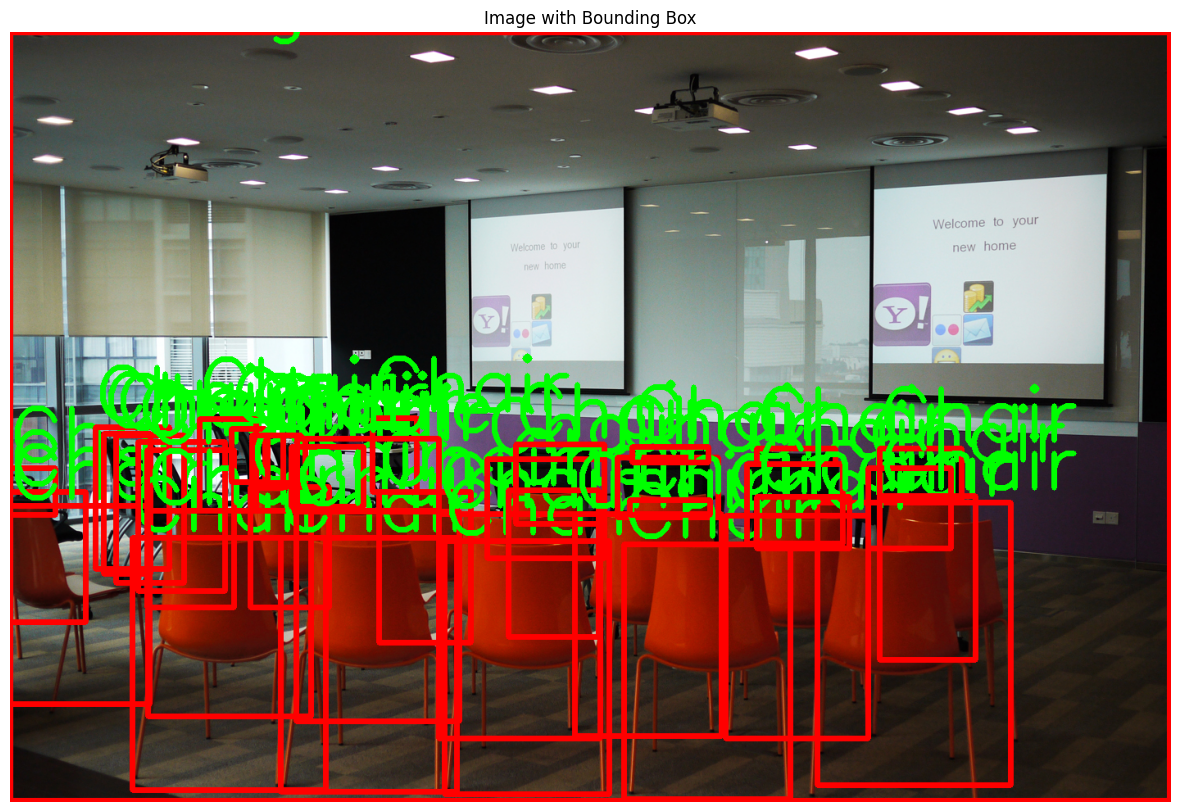

In [50]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [54]:
import pandas as pd
import os

# Assuming these are your label names and classes
label_names = [label_name_bed, label_name_chair, label_name_table]
classes = ['bed', 'chair', 'table']

# Initialize empty DataFrames with correct columns
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Assuming annotations_bbox is your existing DataFrame
# and test_path is your path to test images
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for img_name in test_imgs:
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID'] == img_id]

    data_to_append = []

    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                data_to_append.append({
                    'FileName': img_name,
                    'XMin': row['XMin'],
                    'XMax': row['XMax'],
                    'YMin': row['YMin'],
                    'YMax': row['YMax'],
                    'ClassName': classes[i]
                })

    if data_to_append:
        if 'val' in img_name.lower():
            val_df = pd.concat([val_df, pd.DataFrame(data_to_append)], ignore_index=True)
        elif 'test' in img_name.lower():
            test_df = pd.concat([test_df, pd.DataFrame(data_to_append)], ignore_index=True)

    sys.stdout.write(f'Parsed test_imgs {img_name}; Number of boxes: {len(val_df) if "val" in img_name.lower() else len(test_df)}\r')
    sys.stdout.flush()

# Optionally reset index


In [55]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [56]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      train_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [57]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      test_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')